In [1]:
import numpy as np
import pandas as pd

from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy import integrate

import matplotlib.pyplot as plt

In [2]:
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy

In [3]:
def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    #df_adjusted=df_camera-df_fitting
    return df_camera-df_fitting

In [4]:
filename_cam='datasets/galadriel_dataset_24_09_18_cam.npy'

In [5]:
#read the data
with open(filename_cam,'rb') as f:
    camera_list=np.load(f)
    
#get the background array
background=camera_list[0]
camera_list=camera_list[1:]
#substract the background
camera_clean=camera_list.astype(np.int16)-background.astype(np.int16)
camera_clean[camera_clean<0]=0 #remove negative values

In [6]:
print(camera_clean[0])
print(background)
#print(camera_list[0].astype(np.int16)-background.astype(np.int16))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 88  94  92 ...  93  85 107]
 [172 183 179 ... 190 171 201]
 [187 202 185 ... 192 176 199]
 ...
 [176 181 175 ... 183 171 192]
 [184 181 179 ... 181 168 194]
 [181 181 184 ... 183 164 192]]


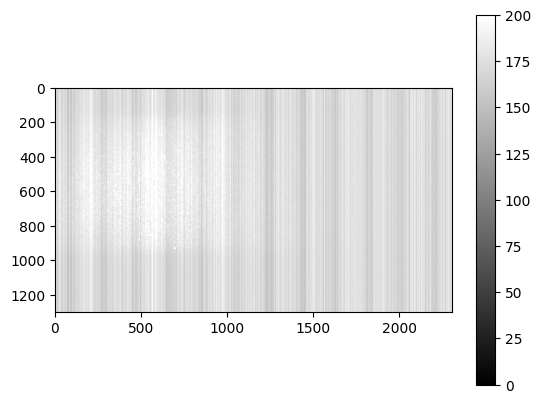

In [7]:
plt.imshow(background,cmap='gray',vmin=0,vmax=200)
plt.colorbar(orientation='vertical')

(1200.0, 0.0)

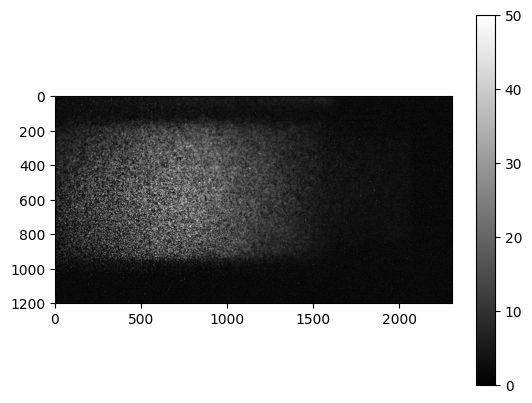

In [8]:
plt.imshow(camera_clean[1],cmap='gray',vmin=0,vmax=50)
plt.colorbar(orientation='vertical')
plt.ylim(1200,0)

In [9]:
#the counts outside the range depend on the temperature (so time in the experiment)

(1200.0, 1100.0)

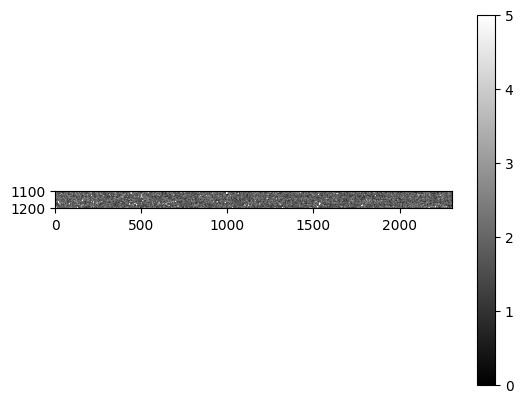

In [10]:
plt.imshow(camera_clean[4],cmap='gray',vmin=0,vmax=5)
plt.colorbar(orientation='vertical')
plt.ylim(1200,1100)

# Analysis of the electron spectrum for ALL shots

In [11]:
filename='datasets/galadriel_dataset_24_09_18_phys.h5'

In [12]:
df_input=pd.read_hdf(filename,'df_input')
df_camera=pd.read_hdf(filename,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4  Laser Energy
0          172691  35300.0 -17000.0 -4750000.0      0.001748
1          172692  35300.0 -17000.0 -4750000.0      0.001762
2          172693  35300.0 -17000.0 -4750000.0      0.001785
3          172694  35300.0 -17000.0 -4750000.0      0.001697
4          172695  34800.0 -13000.0 -5050000.0      0.004275
...           ...      ...      ...        ...           ...
3569       176260  34800.0  11000.0 -5350000.0      0.004952
3570       176261  34800.0  11000.0 -5350000.0      0.005166
3571       176262  34800.0  11000.0 -5350000.0      0.004867
3572       176263  34800.0  11000.0 -5350000.0      0.005132
3573       176264  34800.0  11000.0 -5350000.0      0.005383

[3574 rows x 5 columns]
----
Camera 1D
         0        1        2        3        4        5        6        7     \
0      6.1000   6.1075   6.7050   5.7650   6.4175   5.4300   6.8350   5.7300   
1     11.3200  11.6300  12.1400  11.7350  11.9700  11.5975 

In [13]:
df_input.describe()

,shot number,order2,order3,order4,Laser Energy
count,3574.000000,3574.000000,3574.000000,3.574000e+03,3574.000000
mean,174477.500000,34899.888081,3005.595971,-4.750000e+06,0.004359
std,1031.869259,316.245447,14967.077295,4.243828e+05,0.001299
min,172691.000000,34400.000000,-21000.000000,-5.350000e+06,0.001582
25%,173584.250000,34600.000000,-9000.000000,-5.050000e+06,0.003293
50%,174477.500000,34900.000000,3000.000000,-4.750000e+06,0.004734
75%,175370.750000,35200.000000,15000.000000,-4.450000e+06,0.005307
max,176264.000000,35400.000000,27000.000000,-4.150000e+06,0.006788


Text(0.5, 0, 'Pixels')

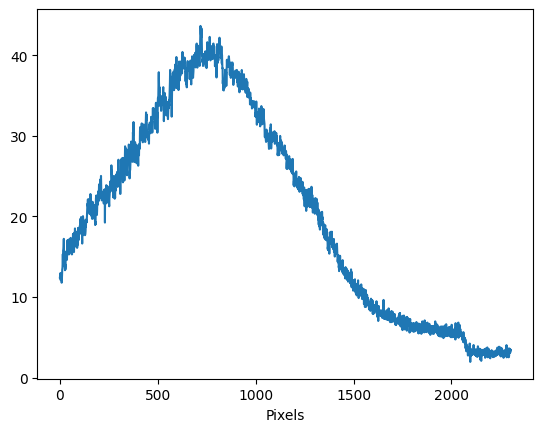

In [14]:
e_dist=df_camera.loc[200]
x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
#plt.plot(MeV,e_dist)
#plt.xlabel('Energy(MeV)')
#plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

### Temperature analysis

In [15]:
cam_sum=df_camera.sum(axis=1)/len(df_camera.columns)

1.0064693399569614e-06 0.0068220736766973575 13.189859118446714


Text(0, 0.5, 'Number of count per pixel')

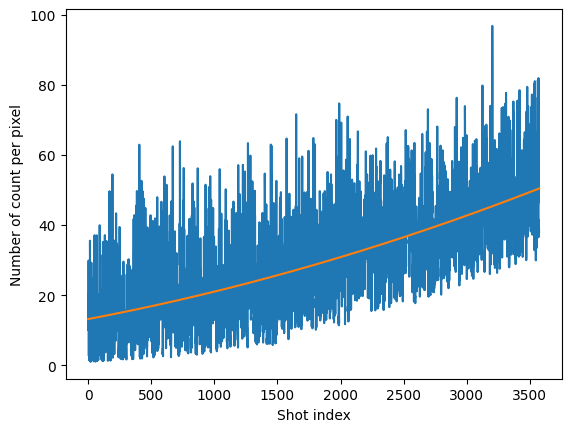

In [16]:
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
p1,p2,b = np.polyfit(x, cam_sum, 2)
print(p1,p2,b)
fitting=p1*x**2+p2*x+b

plt.plot(cam_sum)
plt.plot(fitting)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

In [17]:
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
adj=p1*x**2+p2*x

In [18]:
cam_sum_adj=cam_sum-adj

Text(0, 0.5, 'Number of count per pixel')

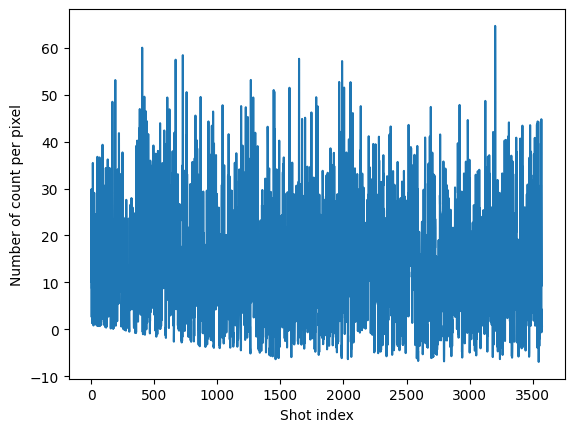

In [19]:
plt.plot(cam_sum_adj)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

In [20]:
#function that takes the camera data and removes the temperautre effect
#1 calculate the total number of counts per shot
#2 fit a 2 order polynomial to this
#3 remove the trend from original data
def rmv_tmp_effect(df_camera):
    #1 calculate the average number of counts per shot
    cam_avg=df_camera.sum(axis=1)/len(df_camera.columns)
    
    #2 fit a 2 order polynomial to this
    x=np.linspace(0,len(cam_avg)-1,len(cam_avg))
    p1,p2,b = np.polyfit(x, cam_avg, 2)
    #print(p1,p2,b)

    adj=p1*x**2+p2*x #each shot needs to be adjusted by this value (x is shot index)
    #print(df_camera.sub(adj,axis=0))
    return df_camera.sub(adj,axis=0)

In [21]:
df_camera_no_tmp=rmv_tmp_effect(df_camera)

5.45084772153759e-22 -5.53071638955693e-18 13.18985911844671


Text(0, 0.5, 'Number of count per pixel')

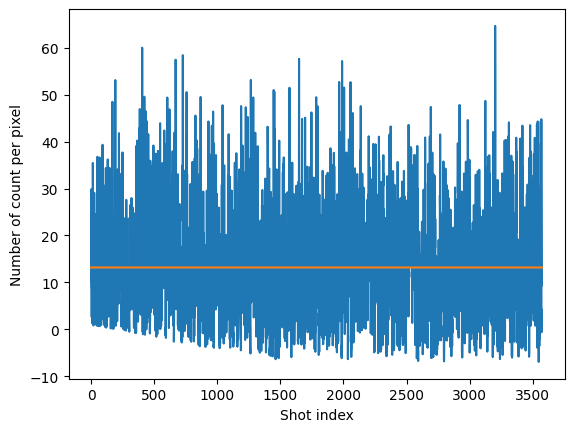

In [22]:
cam_sum=df_camera_no_tmp.sum(axis=1)/len(df_camera_no_tmp.columns)
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
p1,p2,b = np.polyfit(x, cam_sum, 2)
print(p1,p2,b)
fitting=p1*x**2+p2*x+b

plt.plot(cam_sum)
plt.plot(fitting)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

## SMOOTH THE DATA and drop last values

In [23]:
#smooth the whole camera dataframe
df_camera_smooth=df_camera_no_tmp.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')

df_camera_smooth=df_camera_smooth.iloc[:,0:2000].copy()

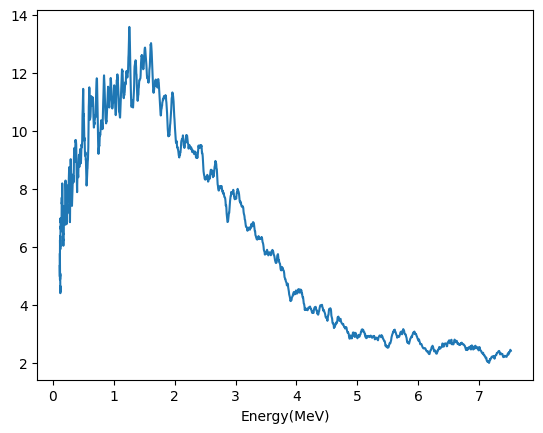

Text(0.5, 0, 'Pixels')

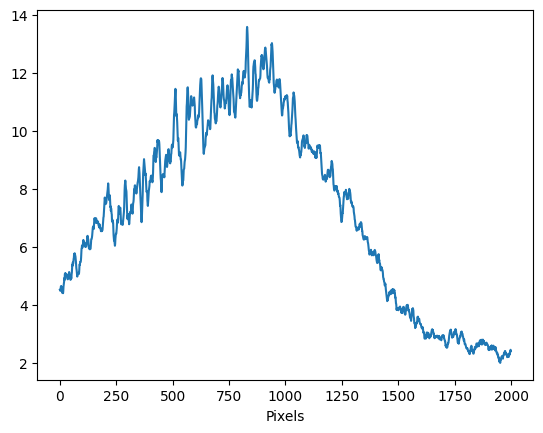

In [24]:
e_dist=df_camera_smooth.loc[208]
x=np.linspace(0,len(df_camera_smooth.columns)-1,len(df_camera_smooth.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

## Remove the avg

In [25]:
lastpoints=300
df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)

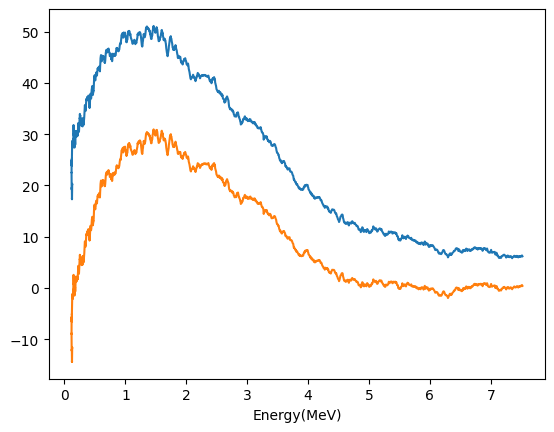

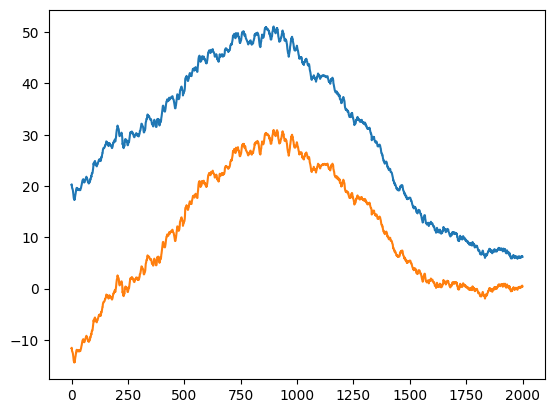

In [26]:
shot_index=2450
#fitting=coef.iloc[shot_index][0]*x+coef.iloc[shot_index][1]
e_dist=df_camera_smooth.loc[shot_index]
e_dist_adj=df_camera_adjusted.loc[shot_index]

MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.plot(MeV,e_dist_adj)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
#plt.plot(fit[shot_index])
plt.plot(x,e_dist_adj)

### Look for the maximum

In [27]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]
        
#Look for max location using the fitting function
#Returns the 'pixel' location of the maximum
def find_max_old(e_dist):
    try:
        #print(e_dist)
        x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #print(len(e_dist)-1,e_dist[1])
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x,e_dist,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]

781.0034741016808
[30.091450818379393, 1, 1]
[28.23423909  1.23576476  0.8734635 ]


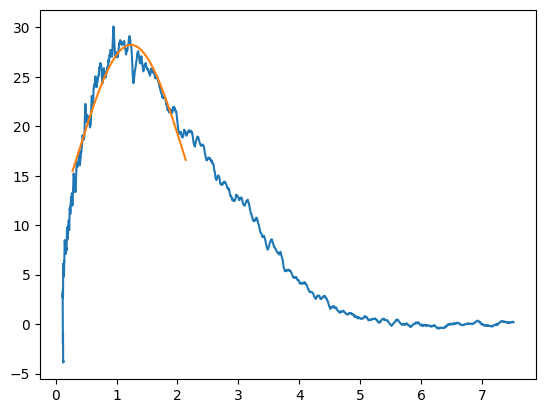

In [28]:
e_dist_adj=df_camera_adjusted.loc[200]
#x=np.linspace(0,len(df_camera_adjusted.columns)-1,len(df_camera_adjusted.columns))
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

e_zoom=e_dist_adj[int(0.5*np.argmax(e_dist_adj)):int(1.5*np.argmax(e_dist_adj))]
x_zoom=np.linspace(int(0.5*np.argmax(e_dist_adj)),int(1.5*np.argmax(e_dist_adj))-1,len(e_zoom))

print(find_max(e_dist_adj))

#fitting in the energy domain
#around the peak
p0=[np.max(e_dist_adj),1,1]#initial guess
print(p0)

x_ene_zoom=conv_energy(x_zoom)

popt=fitting(x_ene_zoom,e_zoom,p0)
print(popt)
y_fit=func(x_ene_zoom,popt[0],popt[1],popt[2])
plt.plot(x_ene,e_dist_adj)
plt.plot(x_ene_zoom,y_fit)
plt.show()

## Cut-off

In [29]:
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss
    
#input a single shot and returns the position of the cut-off
#This will be SLOWER than the other approach
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

## Area behind curve

In [30]:
def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

Integral: 83.7680637996312


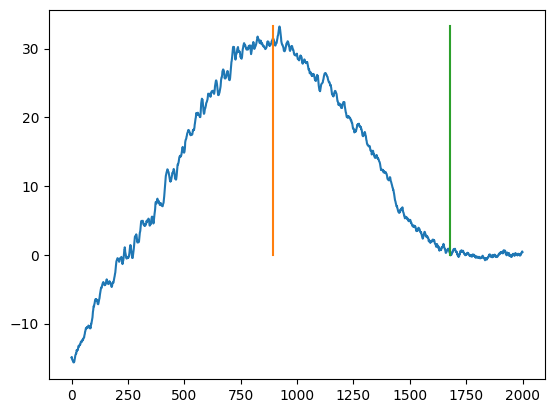

Text(0.5, 0, 'MeV')

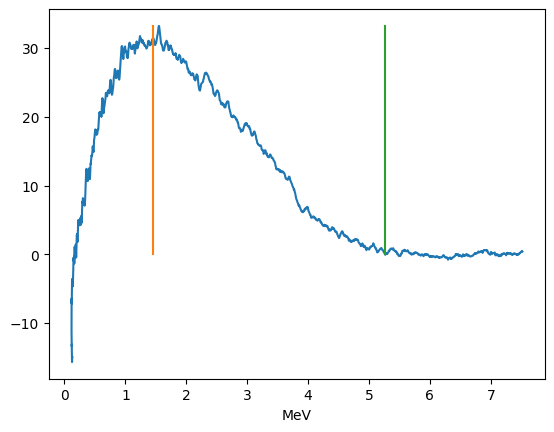

In [31]:
e_dist=df_camera_adjusted.loc[1012]

maxpos=find_max(e_dist)
cutoff_pos=get_cutoff(e_dist,maxpos)

#integrate
print('Integral:',integr(e_dist))

x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))

yaux=np.linspace(0,np.max(e_dist),10)
xaux_max=0*yaux+maxpos
xaux_cutoff=0*yaux+cutoff_pos
plt.plot(e_dist)
plt.plot(xaux_max,yaux)
plt.plot(xaux_cutoff,yaux)
plt.show()

#in energy
x_ene=conv_energy(x)
x_max_ene=conv_energy(xaux_max)
x_cutoff_ene=conv_energy(xaux_cutoff)
plt.plot(x_ene,e_dist)
plt.plot(x_max_ene,yaux)
plt.plot(x_cutoff_ene,yaux)
plt.xlabel('MeV')

## Construct the dataframe with metrics

In [32]:
df_metrics=pd.DataFrame()
df_metrics['Max E']=df_camera_adjusted.apply(find_max,axis=1)
#convert to Energy
df_metrics['Max E']=df_metrics['Max E'].apply(conv_energy)

/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


In [33]:
#calculate hte cutoff energy
df_metrics['Cutoff E']=df_camera_adjusted.apply(get_cutoff_2,axis=1)
#convert to Energy
df_metrics['Cutoff E']=df_metrics['Cutoff E'].apply(conv_energy)

/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

In [34]:
#calculate the integral
df_metrics['Integr']=df_camera_adjusted.apply(integr,axis=1)

/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_64756/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


In [35]:
df_metrics['Integr norm']=df_metrics['Integr'].div(df_input['Laser Energy'])

In [36]:
df_metrics[['Integr','Integr norm']]

,Integr,Integr norm
0,35.431343,20272.315326
1,67.059183,38053.484572
2,61.553257,34487.520418
3,108.605789,63991.126934
4,73.721970,17246.863251
...,...,...
3569,-0.001314,-0.265317
3570,-0.365137,-70.687492
3571,9.057636,1860.849144
3572,4.061687,791.424585


Text(0, 0.5, 'Num. shots')

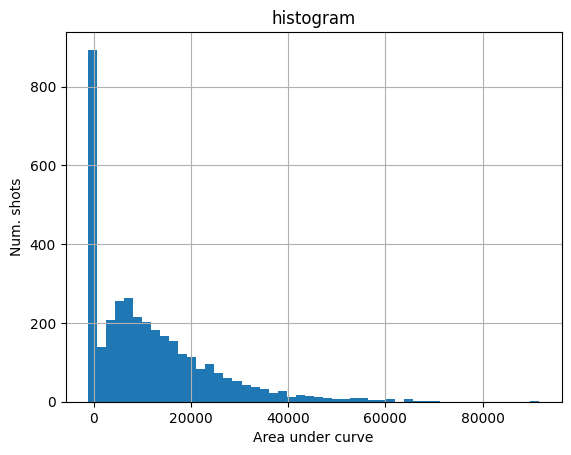

In [37]:
df_metrics['Integr norm'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Area under curve')
plt.ylabel('Num. shots')

Text(0, 0.5, 'Num. shots')

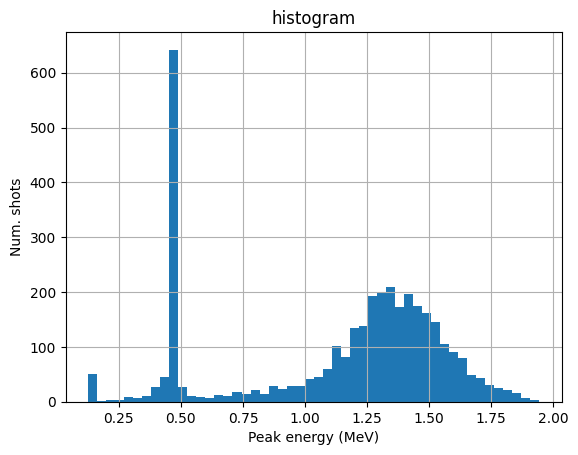

In [38]:
df_metrics['Max E'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Peak energy (MeV)')
plt.ylabel('Num. shots')

### Analyzing the shots with huge energy

In [39]:
df_metrics_bad=df_metrics[df_metrics['Max E']<0.6]

bad_shots_list=df_metrics_bad.index.values
#print(good_shots_list)
#remove those wrong points fromt he input list
df_input_bad=df_input.iloc[bad_shots_list]
df_camera_bad=df_camera.iloc[bad_shots_list]

#reset the indexes
df_metrics_bad.reset_index(inplace=True,drop=True)
df_input_bad.reset_index(inplace=True,drop=True)
df_camera_bad.reset_index(inplace=True,drop=True)

In [40]:
df_input_bad

,shot number,order2,order3,order4,Laser Energy
0,172696,34800.0,-13000.0,-5050000.0,0.004480
1,172700,34400.0,-5000.0,-5350000.0,0.005667
2,172702,34400.0,-5000.0,-5350000.0,0.005500
3,172703,34400.0,-5000.0,-5350000.0,0.005359
4,172704,34400.0,-5000.0,-5350000.0,0.005348
...,...,...,...,...,...
838,176248,34700.0,-9000.0,-4450000.0,0.003469
839,176249,34700.0,-9000.0,-4450000.0,0.003667
840,176260,34800.0,11000.0,-5350000.0,0.004952
841,176261,34800.0,11000.0,-5350000.0,0.005166


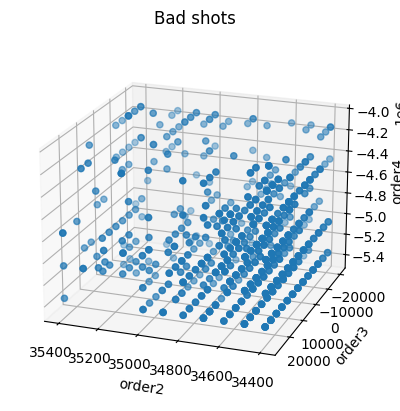

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_input_bad['order2'], df_input_bad['order3'], df_input_bad['order4'])
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.set_zlim(-5.5e6,-4e6)
ax.view_init(elev=20., azim=110)
plt.title('Bad shots')
plt.show()

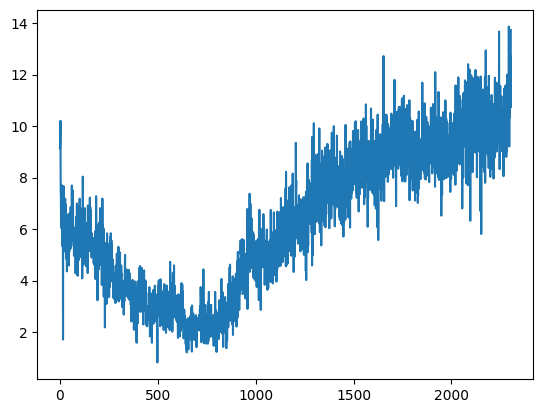

In [42]:
shot_index=310
e_dist=df_camera_bad.loc[shot_index]
shot_numb=df_input_bad['shot number'].loc[shot_index]
plt.plot(e_dist)

## Drop te shots with wrong max E (are the same with wrong integral)

In [43]:
df_metrics_reduced=df_metrics[df_metrics['Max E']>0.5]

good_shots_list=df_metrics_reduced.index.values
#print(good_shots_list)
#remove those wrong points fromt he input list
df_input_reduced=df_input.iloc[good_shots_list]

#reset the indexes
df_metrics_reduced.reset_index(inplace=True,drop=True)
df_input_reduced.reset_index(inplace=True,drop=True)

Text(0, 0.5, 'Num. shots')

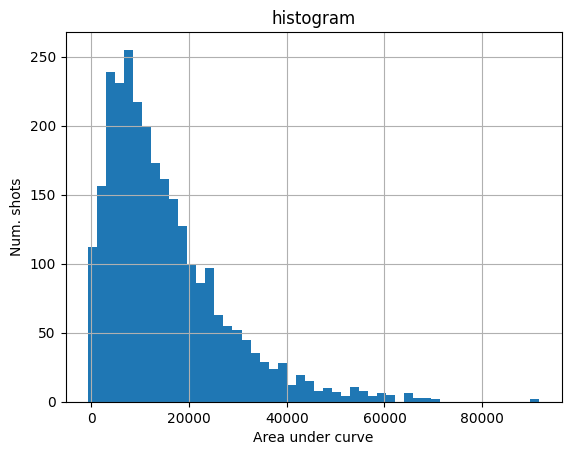

In [44]:
df_metrics_reduced['Integr norm'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Area under curve')
plt.ylabel('Num. shots')

## Average shots

In [45]:
#Average shots with same input param
#NOTE: the 'integ' values are the normalized
def metric_shot_average(df_input,df_metrics):
    emax_list=[]
    ecut_list=[]
    integ_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    emax_mean=[]
    emax_std=[]
    ecut_mean=[]
    ecut_std=[]
    integ_mean=[]
    integ_std=[]
    integ_mean=[]
    integ_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            emax_list.append(df_metrics['Max E'].iloc[index])
            ecut_list.append(df_metrics['Cutoff E'].iloc[index])
            integ_list.append(df_metrics['Integr norm'].iloc[index])
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                emax_list.append(df_metrics['Max E'].iloc[index])
                ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the calc
                emax_mean.append(np.mean(emax_list))
                emax_std.append(np.std(emax_list))
                ecut_mean.append(np.mean(ecut_list))
                ecut_std.append(np.std(ecut_list))
                integ_mean.append(np.mean(integ_list))
                integ_std.append(np.std(integ_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                #start the new batch
                emax_list=[df_metrics['Max E'].iloc[index]]
                ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_metrics_avg=pd.DataFrame()
    df_metrics_avg['order2']=o2_list
    df_metrics_avg['order3']=o3_list
    df_metrics_avg['order4']=o4_list
    df_metrics_avg['Emax mean']=emax_mean
    df_metrics_avg['Emax std']=emax_std
    df_metrics_avg['Ecut mean']=ecut_mean
    df_metrics_avg['Ecut std']=ecut_std
    df_metrics_avg['Integr mean']=integ_mean
    df_metrics_avg['Integr std']=integ_std
    return df_metrics_avg

In [46]:
df_metrics_avg=metric_shot_average(df_input_reduced,df_metrics_reduced)

In [47]:
df_metrics_avg

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
0,35300.0,-17000.0,-4750000.0,1.171111,0.130331,5.442997,0.233745,39201.111812,15782.737233
1,34800.0,-13000.0,-5050000.0,1.306748,0.164159,5.457378,0.111727,13533.917651,4876.878349
2,34400.0,-5000.0,-5350000.0,0.772202,0.000000,4.864612,0.000000,1142.292246,0.000000
3,34800.0,-17000.0,-4450000.0,1.494858,0.235228,5.300854,0.397416,26106.011330,18690.841743
4,34600.0,15000.0,-5350000.0,0.651573,0.079900,3.621259,1.392441,2750.246573,2354.227102
...,...,...,...,...,...,...,...,...,...
682,34500.0,15000.0,-4450000.0,1.241422,0.280237,3.868997,0.288744,4302.329069,2547.746194
683,34400.0,-13000.0,-4450000.0,1.312405,0.512862,2.338690,1.541328,2541.932092,3013.742610
684,34700.0,-9000.0,-4450000.0,1.431090,0.007193,4.056676,0.269376,8969.177105,4175.831917
685,35200.0,-13000.0,-4750000.0,1.291376,0.131705,4.516234,0.632082,34947.333198,18900.922883


In [48]:
print(df_metrics_avg[df_metrics_avg['Integr mean']>30000])

      order2   order3     order4  Emax mean  Emax std  Ecut mean  Ecut std  \
0    35300.0 -17000.0 -4750000.0   1.171111  0.130331   5.442997  0.233745   
17   35100.0 -17000.0 -4750000.0   1.293293  0.195839   5.308451  0.228441   
28   35400.0  -5000.0 -4750000.0   1.407306  0.123702   5.612678  0.134399   
43   35400.0 -17000.0 -5350000.0   1.228831  0.169864   5.473492  0.017278   
45   35000.0 -13000.0 -4450000.0   1.344500  0.124949   5.430836  0.057553   
49   35200.0 -21000.0 -4750000.0   1.228624  0.041223   5.466052  0.096223   
64   35400.0 -17000.0 -4750000.0   1.161535  0.164371   5.363492  0.203554   
74   35300.0  -1000.0 -5050000.0   1.430619  0.063890   5.548990  0.116398   
82   35400.0  -1000.0 -5350000.0   1.285451  0.089950   5.532890  0.083992   
90   34800.0  -5000.0 -4150000.0   1.464594  0.080305   5.521346  0.349917   
108  35300.0   3000.0 -4450000.0   1.332940  0.142124   5.430957  0.076347   
113  35300.0  -9000.0 -4750000.0   1.438286  0.138773   5.483968

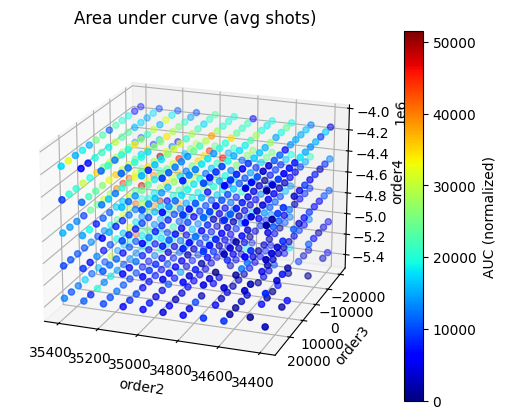

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d=ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['order4'],c=df_metrics_avg['Integr mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.set_zlim(-5.5e6,-4e6)
ax.view_init(elev=20., azim=110)
plt.title('Area under curve (avg shots)')
cbar =fig.colorbar(plot_3d,ax=ax)
cbar.set_label('AUC (normalized)')
plt.show()

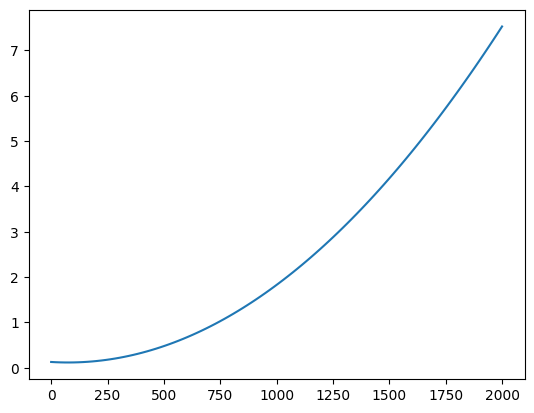

In [57]:
x=np.linspace(0,2000,100)
y=conv_energy(x)
plt.plot(x,y)